### Importing Packages

In [37]:
from sdv.metadata import Metadata
import pandas as pd
from scipy.stats import entropy
import numpy as np
from sdmetrics.single_column import TVComplement
from sdmetrics.single_column import RangeCoverage, KSComplement
from table_evaluator import load_data, TableEvaluator


### Loading the Data 

In [38]:
# 1. User Parameters
dataset_name = "diabetes"
generator_name = "tvae"

# 2. Paths
real_path = f"../data/processed/{dataset_name}_train.csv"
test_path = f"../data/processed/{dataset_name}_test.csv"
synth_path = f"../data/synthetic/{generator_name}/{dataset_name}_{generator_name}.csv"

# 3. Load Data
real_df = pd.read_csv(real_path)
synth_df = pd.read_csv(synth_path)
test_df = pd.read_csv(test_path)

#### SDV Overall Score, Column Shapes, and Pair Trends

In [6]:
metadata = Metadata.detect_from_dataframe(real_df)

In [7]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

diagnostic = run_diagnostic(
    real_data=real_df,
    synthetic_data=synth_df,
    metadata=metadata
)

quality_report = evaluate_quality(
    real_df,
    synth_df,
    metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 244.42it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 641.72it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 51.45it/s]|
Column Shapes Score: 95.1%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 55.94it/s]|
Column Pair Trends Score: 92.05%

Overall Score (Average): 93.57%



#### Range Coverage, KS, and KL (Averages)

In [11]:
# Identify numerical columns
numerical_columns = real_df.select_dtypes(include='number').columns

range_coverages = []
ks_complements = []
kl_divergences = []

# Calculate metrics for each numeric column
for col in numerical_columns:
    real_col = real_df[col].dropna()
    fake_col = synth_df[col].dropna()

    # Match lengths if needed
    min_len = min(len(real_col), len(fake_col))
    real_col = real_col.iloc[:min_len]
    fake_col = fake_col.iloc[:min_len]

    # --- Range Coverage ---
    range_cov = RangeCoverage.compute(
        real_data=real_col,
        synthetic_data=fake_col
    )
    range_coverages.append(range_cov)

    # --- KS Complement ---
    ks = KSComplement.compute(
        real_data=real_col,
        synthetic_data=fake_col
    )
    ks_complements.append(ks)

    # --- KL Divergence ---
    bins = np.histogram_bin_edges(np.concatenate([real_col, fake_col]), bins=10)
    p_hist, _ = np.histogram(real_col, bins=bins, density=True)
    q_hist, _ = np.histogram(fake_col, bins=bins, density=True)

    epsilon = 1e-10
    p = (p_hist + epsilon) / np.sum(p_hist + epsilon)
    q = (q_hist + epsilon) / np.sum(q_hist + epsilon)

    kl = entropy(p, q)
    kl_divergences.append(kl)

# Compute mean and std for each metric
def describe(metric_list, name):
    mean = np.mean(metric_list)
    std = np.std(metric_list)
    print(f"{name}: {mean:.4f} ± {std:.4f}")

print("\nSummary Statistics Across Numerical Columns:")
describe(range_coverages, "Range Coverage")
describe(ks_complements, "KS Complement")
describe(kl_divergences, "KL Divergence")



Summary Statistics Across Numerical Columns:
Range Coverage: 0.9779 ± 0.0541
KS Complement: 0.9435 ± 0.0448
KL Divergence: 0.0426 ± 0.0667


In [15]:
real_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Male,73.0,0,0,former,24.77,3.5,80,0
1,Male,80.0,0,0,never,24.60,5.7,145,1
2,Female,38.0,0,0,ever,24.33,4.0,158,0
3,Female,26.0,0,0,not current,18.87,5.0,100,0
4,Female,61.0,1,0,current,22.11,4.5,85,0


#### TV Distance

In [17]:
# Select categorical columns
#categorical_columns = real_df.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_columns = ['gender','hypertension','heart_disease','smoking_history','diabetes'] # for stroke

tv_distances = []

for col in categorical_columns:
    real_col = real_df[col].dropna()
    fake_col = synth_df[col].dropna()

    # Ensure equal length
    min_len = min(len(real_col), len(fake_col))
    real_col = real_col.iloc[:min_len]
    fake_col = fake_col.iloc[:min_len]

    tv_complement = TVComplement.compute(
        real_data=real_col,
        synthetic_data=fake_col
    )
    tv_distance = 1 - tv_complement
    tv_distances.append(tv_distance)

    print(f"TV Distance for {col}: {tv_distance:.4f}")

# Compute mean and std
mean_tvd = np.mean(tv_distances)
std_tvd = np.std(tv_distances)

print(f"\nAverage TVD: {mean_tvd:.4f} ± {std_tvd:.4f}")


TV Distance for gender: 0.0044
TV Distance for hypertension: 0.0042
TV Distance for heart_disease: 0.0018
TV Distance for smoking_history: 0.0418
TV Distance for diabetes: 0.0139

Average TVD: 0.0132 ± 0.0149


In [30]:
range_columns = {
    "diabetes": ['bmi', 'HbA1c_level'],
    #"stroke": [...],
    #"cirrhosis": [...],
}

#### Range Coverage and Kolmogorov Smirnov

In [31]:
from sdmetrics.single_column import RangeCoverage, KSComplement
selected_columns = range_columns.get(dataset_name, [])
for col in selected_columns:
    range_cov = RangeCoverage.compute(
        real_data=real_df[col],
        synthetic_data=synth_df[col]
    )
    ks = KSComplement.compute(
        real_data=real_df[col],
        synthetic_data=synth_df[col]
    )
    print(f"Range coverage for {col}: {range_cov:.4f}")
    print(f"KSComplement for {col}: {ks:.4f}")

Range coverage for bmi: 0.8455
KSComplement for bmi: 0.9196
Range coverage for HbA1c_level: 1.0000
KSComplement for HbA1c_level: 0.8892


#### Category Coverage and TV Complement

In [28]:
from sdmetrics.single_column import CategoryCoverage, TVComplement
for i in ['smoking_history','diabetes']:
  cat_cov = CategoryCoverage.compute(
    real_data=df[i],
    synthetic_data=fake[i]
  )
  tv = TVComplement.compute(
      real_data=df[i],
      synthetic_data=fake[i]
  )
  print(f"Category coverage for {i} is: {cat_cov}")
  print(f"TVComplement for {i} is: {tv}")

Category coverage for smoking_history is: 1.0
TVComplement for smoking_history is: 0.98505
Category coverage for diabetes is: 1.0
TVComplement for diabetes is: 0.989475


#### Wasserstein Distance for Numerical Columns (specify columns)

In [40]:
from scipy.stats import wasserstein_distance

In [41]:
wasserstein_distances = {}
for column in test_df.columns[5:]:
    wasserstein_dist = wasserstein_distance(test_df[column], synth_df[column])
    wasserstein_distances[column] = wasserstein_dist

In [42]:
# Print Wasserstein distances for Testing vs Synthetic
for column, distance in wasserstein_distances.items():
    print(f'Comparing Testing data and Synthetic Data {column}: {distance}')

Comparing Testing data and Synthetic Data bmi: 0.8223077499999998
Comparing Testing data and Synthetic Data HbA1c_level: 0.13879624999999995
Comparing Testing data and Synthetic Data blood_glucose_level: 5.310062499999997
Comparing Testing data and Synthetic Data diabetes: 0.014362500000000056


In [45]:
# Calculate KL Divergence for Testing vs Synthetic 
from scipy.stats import entropy
kl_divergences = {}
for column in test_df.columns[5:]:
    kl_divergence = entropy(test_df[column], synth_df[:20000][column])
    kl_divergences[column] = kl_divergence

# Print KL Divergences for each feature
for column, divergence in kl_divergences.items():
    print(f'{column}: {divergence}')

bmi: 0.05895502685231592
HbA1c_level: 0.03963016171552787
blood_glucose_level: 0.08015969446291527
diabetes: inf


#### Table Evaluator

In [46]:
table_evaluator = TableEvaluator(real_df, synth_df)

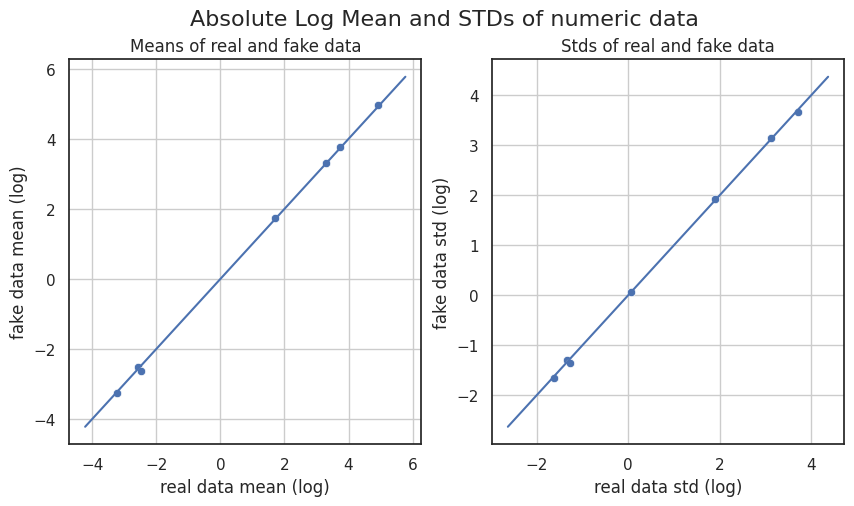

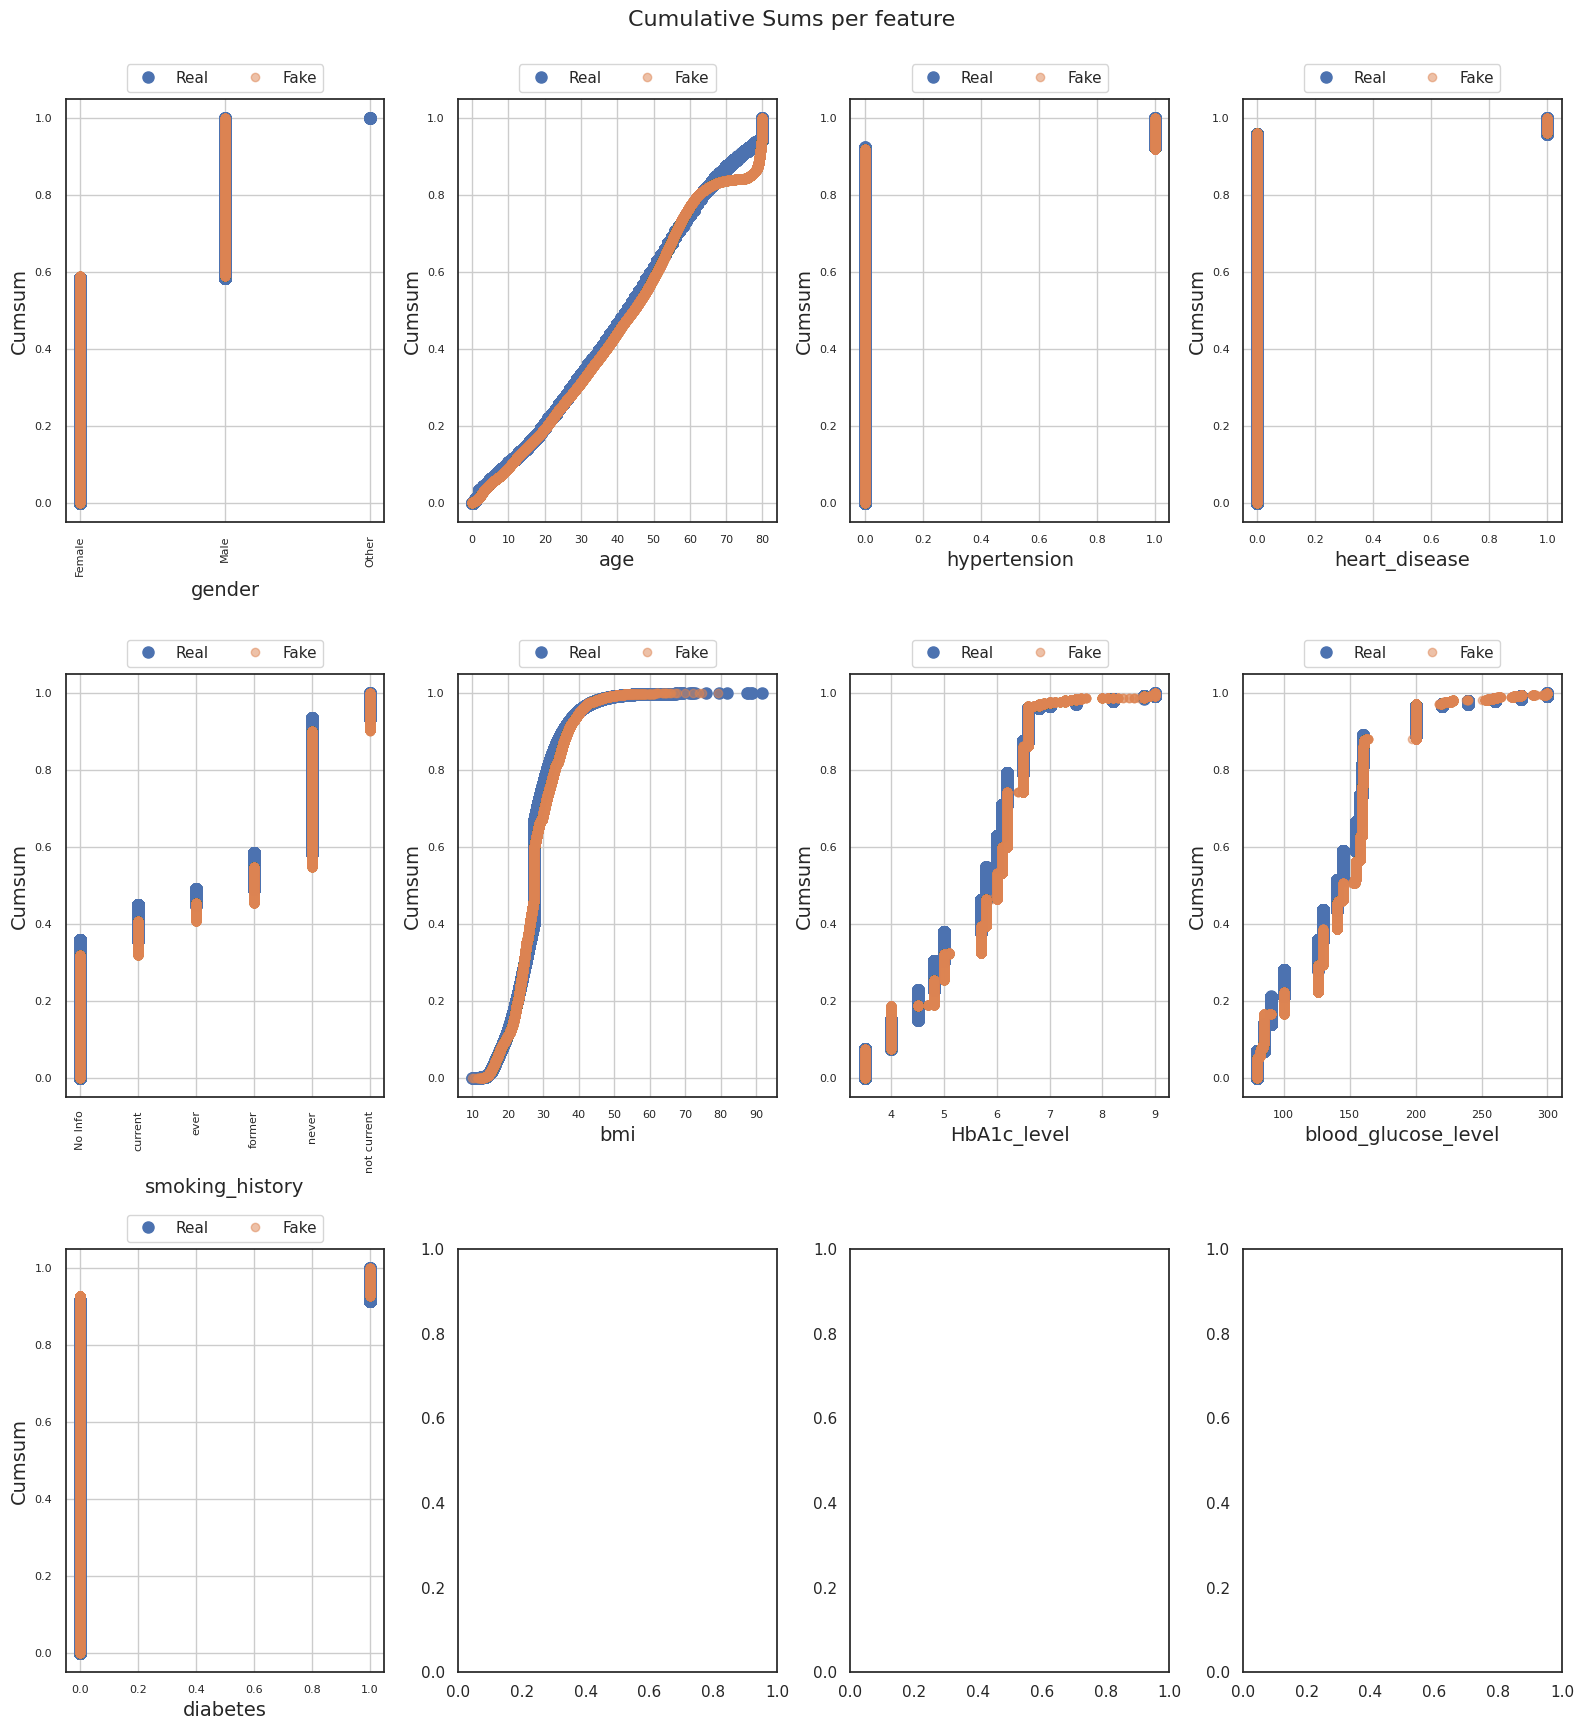

/home/jovyan/paper-realtab/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:270: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/home/jovyan/paper-realtab/lib/python3.11/site-packages/table_evaluator/table_evaluator.py:270: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



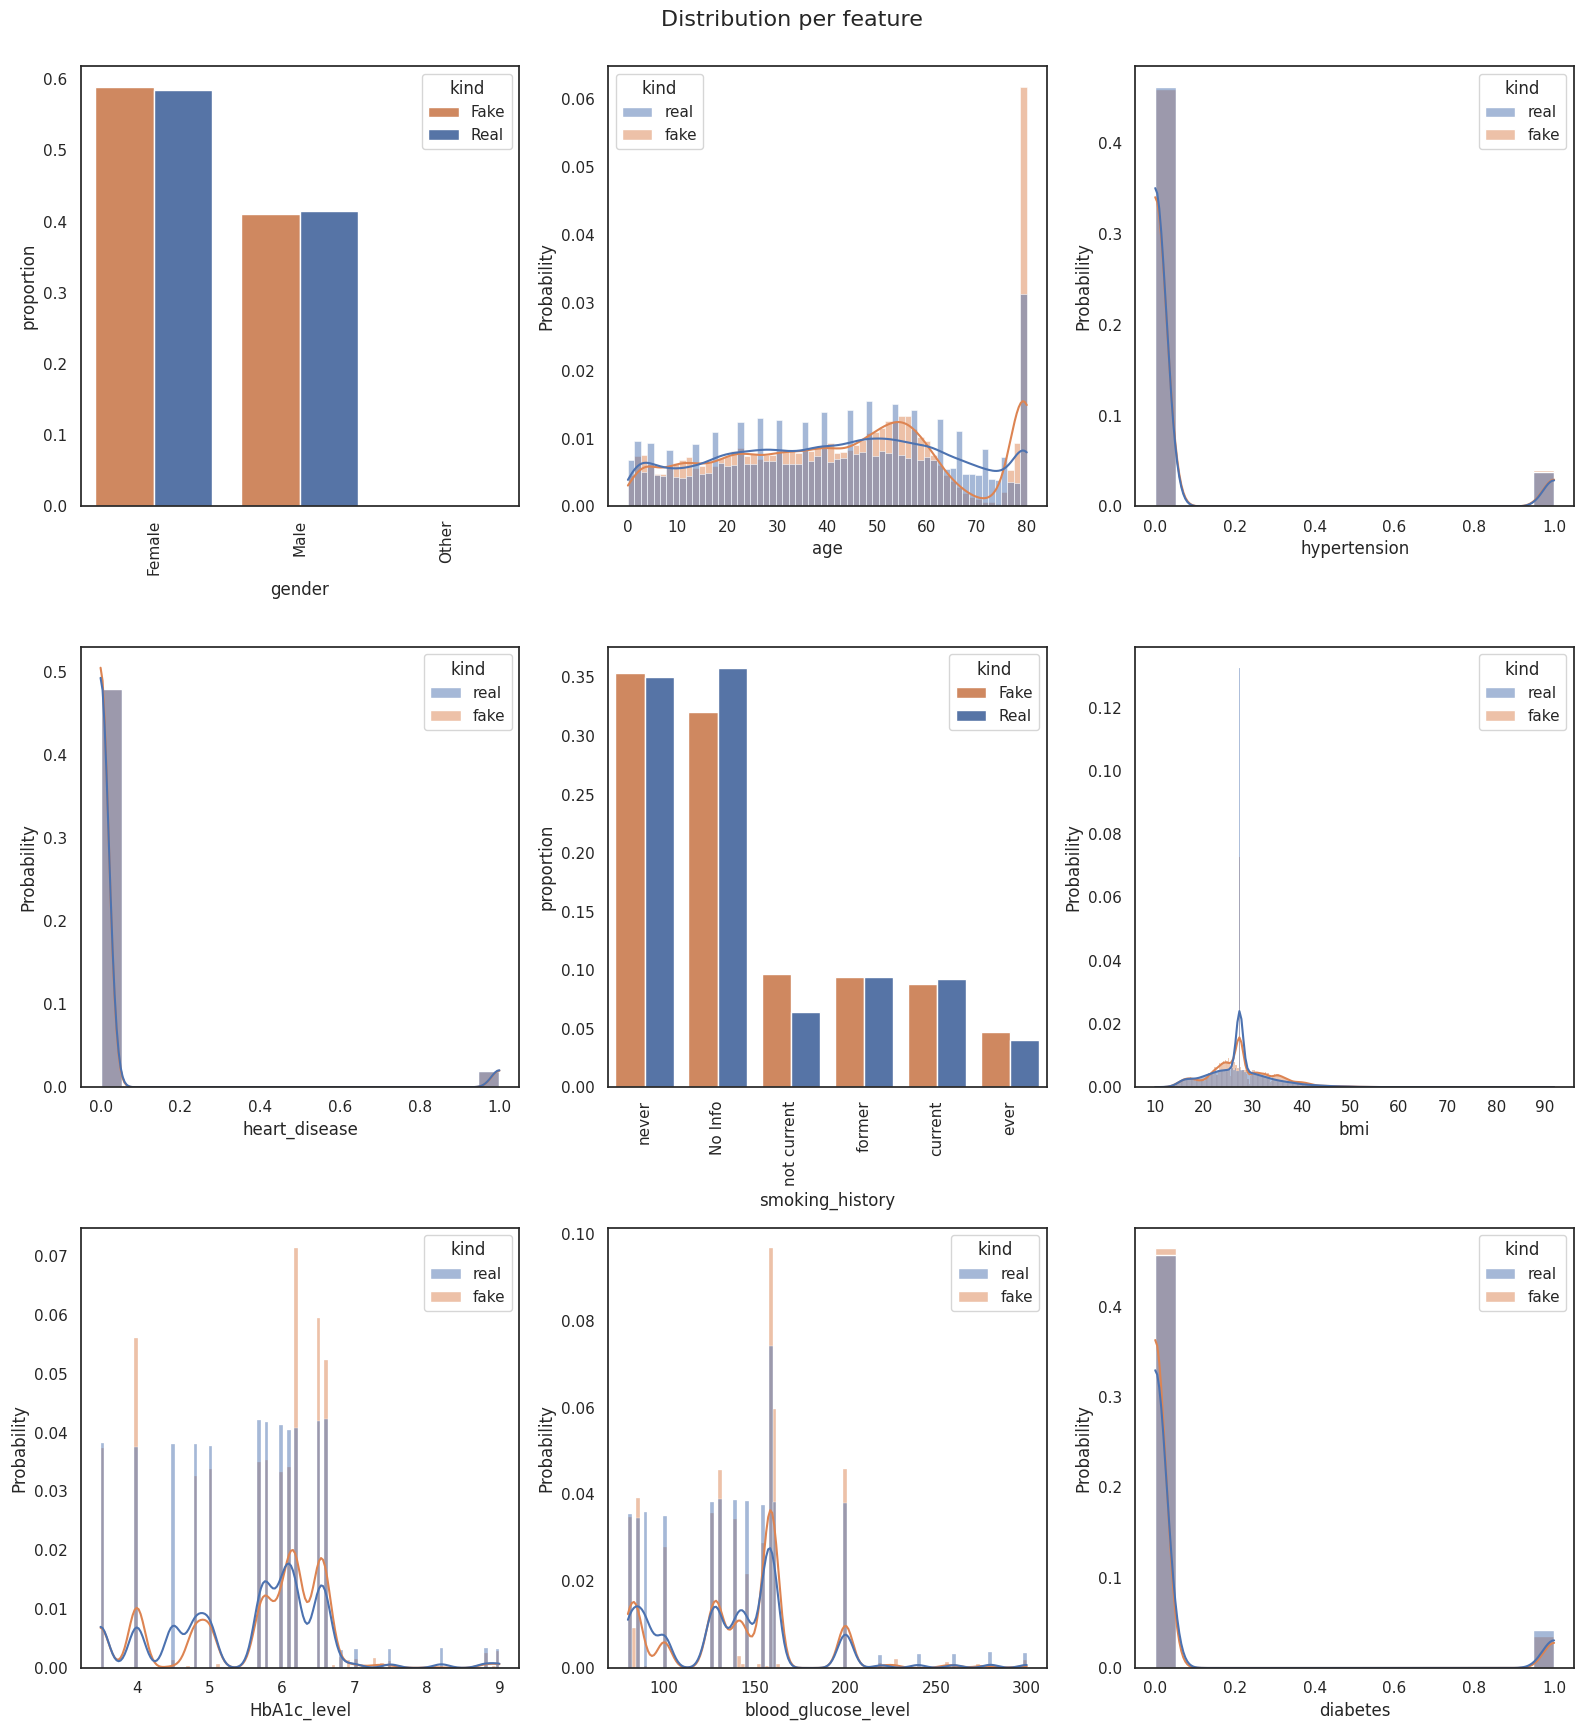

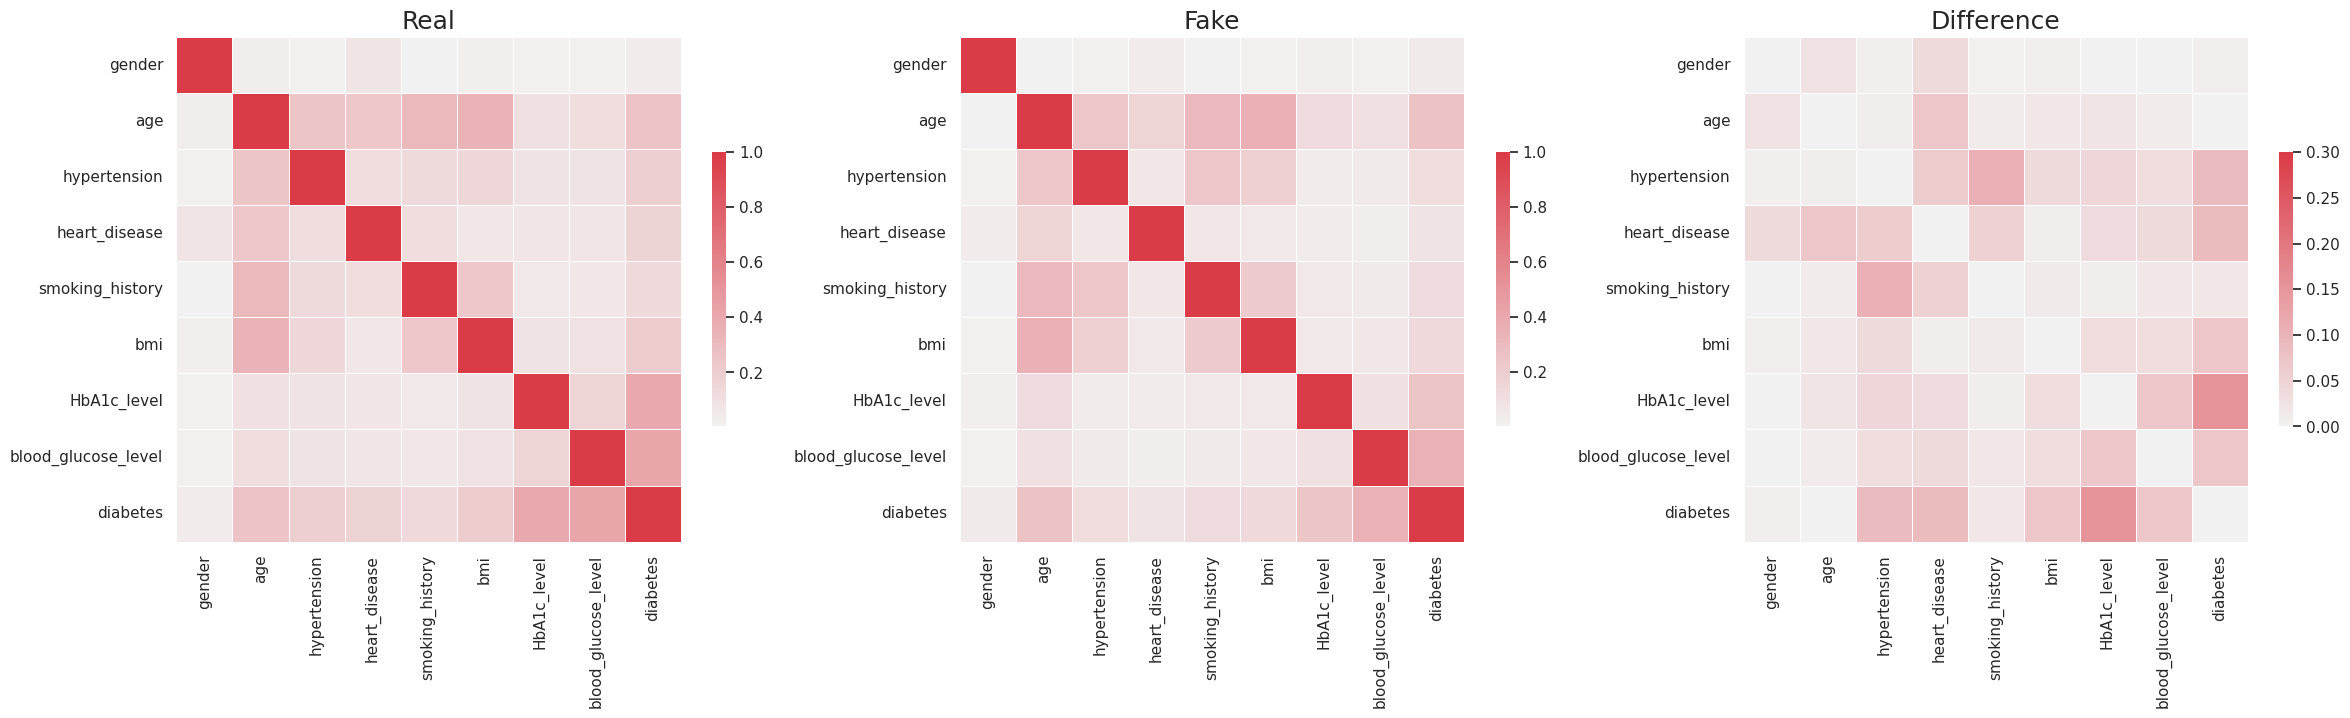

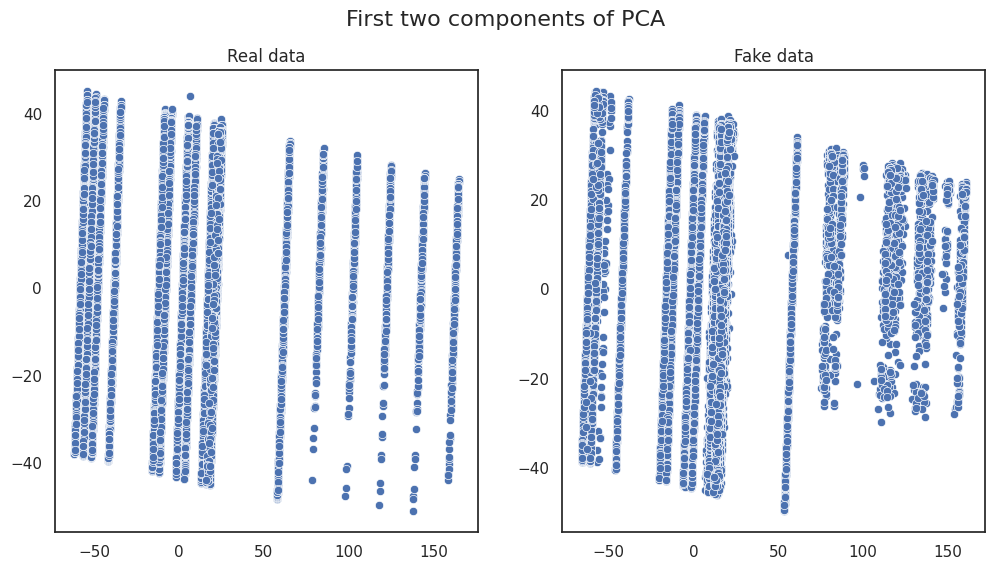

In [47]:
table_evaluator.visual_evaluation()

In [48]:
table_evaluator.evaluate(target_col=dataset_name)

/home/jovyan/paper-realtab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/home/jovyan/paper-realtab/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

Adding column gender_0 with all 0s
Adding column gender_1 with all 0s
Adding column gender_2 with all 0s


[                             f1_real  f1_fake  jaccard_similarity
index                                                            
LogisticRegression_real       0.9611   0.9527              0.9599
LogisticRegression_fake       0.9416   0.9487              0.9439
RandomForestClassifier_real   0.9701   0.9659              0.9747
RandomForestClassifier_fake   0.9566   0.9652              0.9626
DecisionTreeClassifier_real   0.9513   0.9431              0.8880
DecisionTreeClassifier_fake   0.9271   0.9419              0.8614
MLPClassifier_real            0.9671   0.9557              0.9724
MLPClassifier_fake            0.9570   0.9539              0.9723]

Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.9271   0.9419              0.8614
DecisionTreeClassifier_real   0.9513   0.9431              0.8880
LogisticRegression_